### Wildlife Prediction analysis

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import seaborn as sns
from PIL import Image
base_path = 'images' 
for folder in ['train', 'test', 'valid']:
    path = os.path.join(base_path, folder)
    for cls in ['Wildfire', 'NoWildfire']:
        cls_path = os.path.join(path, cls)
        print(f"{folder}/{cls}:", len(os.listdir(cls_path)))
def check_images(folder_path):
    issues = []
    for cls in ['Wildfire', 'NoWildfire']:
        cls_folder = os.path.join(folder_path, cls)
        for fname in os.listdir(cls_folder):
            try:
                img = Image.open(os.path.join(cls_folder, fname))
                img.verify()
            except:
                issues.append(fname)
    return issues

issues_train = check_images(os.path.join(base_path, 'train'))
print("Corrupt images in train:", issues_train)

train/Wildfire: 15750
train/NoWildfire: 14500
test/Wildfire: 3480
test/NoWildfire: 2821
valid/Wildfire: 3480
valid/NoWildfire: 2820
Corrupt images in train: []


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.1, horizontal_flip=True)
test_val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_path, 'train'), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
val_gen = test_val_datagen.flow_from_directory(
    os.path.join(base_path, 'valid'), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)
test_gen = test_val_datagen.flow_from_directory(
    os.path.join(base_path, 'test'), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6302 images belonging to 2 classes.


In [ ]:
# 4. Model A: Custom CNN
# -------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

cnn_model = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(train_gen, epochs=10, validation_data=val_gen)


C:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1419s 3s/step - accuracy: 0.8569 - loss: 0.3301 - val_accuracy: 0.9306 - val_loss: 0.1889
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1242s 3s/step - accuracy: 0.9356 - loss: 0.1768 - val_accuracy: 0.9411 - val_loss: 0.1697
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - accuracy: 0.9407 - loss: 0.1634 - val_accuracy: 0.9567 - val_loss: 0.1199
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1118s 2s/step - accuracy: 0.9492 - loss: 0.1429 - val_accuracy: 0.9562 - val_loss: 0.1286
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1134s 2s/step - accuracy: 0.9519 - loss: 0.1297 - val_accuracy: 0.9590 - val_loss: 0.1128
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1214s 3s/step - accuracy: 0.9558 - loss: 0.1210 - val_accuracy: 0.9603 - val_loss: 0.1252
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1373s 3s/step - accuracy: 0.9586 - loss: 0.1105 - val_accuracy: 0.9624 - val_loss: 0.1065
Epoch 8/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 2798s 6s/step - accuracy: 0.9580 - loss: 0.1174 - 

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# 5. Model B: MobileNetV2 (Transfer Learning)
# -------------------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs, outputs)
mobilenet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

mobilenet_history = mobilenet_model.fit(train_gen, epochs=10, validation_data=val_gen)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1503s 3s/step - accuracy: 0.6650 - loss: 0.6159 - val_accuracy: 0.8557 - val_loss: 0.4327
Epoch 2/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1175s 2s/step - accuracy: 0.8355 - loss: 0.4306 - val_accuracy: 0.8714 - val_loss: 0.3645
Epoch 3/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1009s 2s/step - accuracy: 0.8428 - loss: 0.4013 - val_accuracy: 0.8722 - val_loss: 0.3504
Epoch 4/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1133s 2s/step - accuracy: 0.8404 - loss: 0.4045 - val_accuracy: 0.8692 - val_loss: 0.3480
Epoch 5/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1303s 3s/step - accuracy: 0.8537 - loss: 0.3834 - val_accuracy: 0.8744 - val_loss: 0.3367
Epoch 6/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1492s 3s/step - accuracy: 0.8535 - loss: 0.3796 - val_accuracy: 0.8717 - val_loss: 0.3406
Epoch 7/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1152s 2s/step - accuracy: 0.8566 - loss: 0.3756 - val_accuracy: 0.8729 - val_loss: 0.3386
Epoch 8/10
473/473 ━━━━━━━━━━━━━━━━━━━━ 1

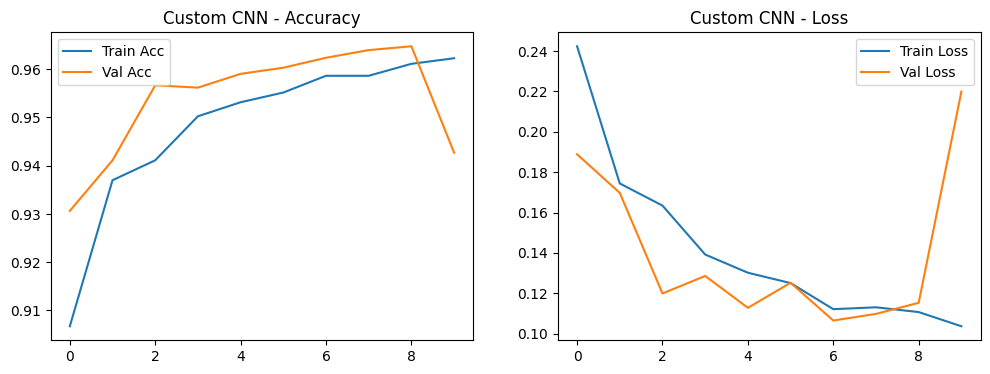

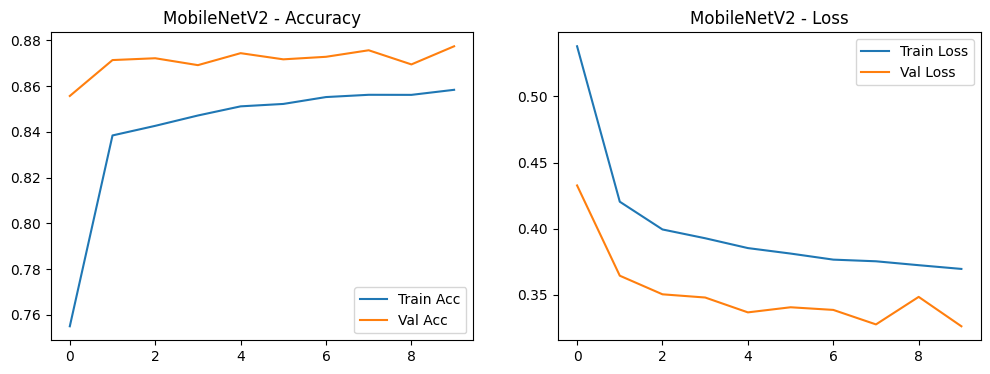

In [6]:
# 6. Evaluation & Comparison
# -------------------------------
def plot_metrics(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_metrics(cnn_history, 'Custom CNN')
plot_metrics(mobilenet_history, 'MobileNetV2')



99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 414ms/step

Custom CNN Classification Report
              precision    recall  f1-score   support

  nowildfire       0.99      0.90      0.94      2822
    wildfire       0.92      0.99      0.95      3480

    accuracy                           0.95      6302
   macro avg       0.95      0.94      0.95      6302
weighted avg       0.95      0.95      0.95      6302



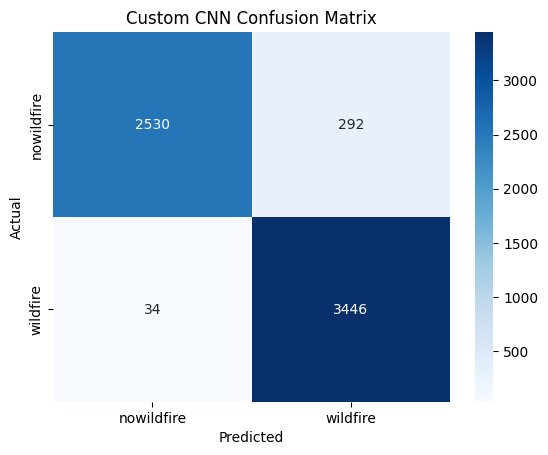

99/99 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step

MobileNetV2 Classification Report
              precision    recall  f1-score   support

  nowildfire       0.89      0.84      0.86      2822
    wildfire       0.88      0.91      0.89      3480

    accuracy                           0.88      6302
   macro avg       0.88      0.88      0.88      6302
weighted avg       0.88      0.88      0.88      6302



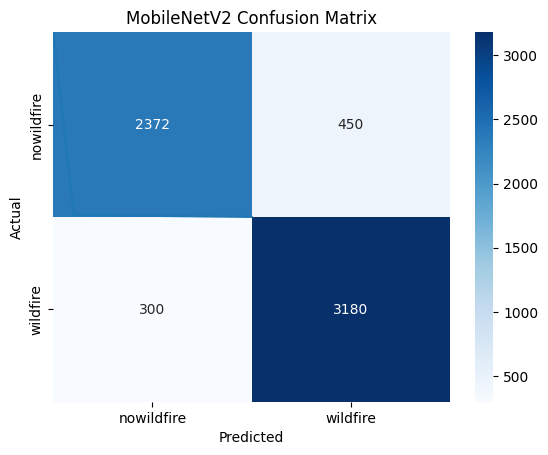

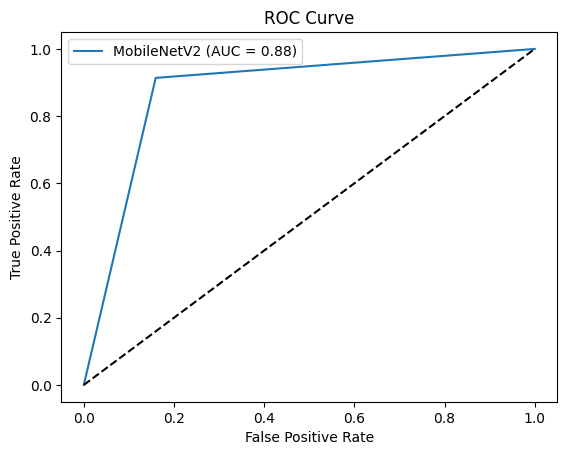

In [8]:
# Test Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Test Evaluation
for name, model in zip(['Custom CNN', 'MobileNetV2'], [cnn_model, mobilenet_model]):
    y_pred = (model.predict(test_gen) > 0.5).astype('int32')
    y_true = test_gen.classes

    print(f"\n{name} Classification Report")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_gen.class_indices,
                yticklabels=test_gen.class_indices)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


